In [0]:
!pip install -i https://test.pypi.org/simple/ supportlib
import supportlib.gettingdata as getdata
getdata.kaggle()

Looking in indexes: https://test.pypi.org/simple/


Saving kaggle.json to kaggle.json


In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 336M/337M [00:04<00:00, 101MB/s] 
100% 337M/337M [00:04<00:00, 76.4MB/s]


In [0]:
getdata.zipextract('/content/cell-images-for-detecting-malaria.zip')

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim

# Any results you write to the current directory are saved as output.

In [0]:
directory = "/content/cell_images"

In [0]:
#create list of both data folders
parasitized = os.listdir('/content/cell_images/Parasitized')
uninfected = os.listdir('/content/cell_images/Uninfected')
label = list()
listdir = {}
for i in range(len(uninfected)):
    uninfected[i] = '/content/cell_images/Uninfected/' + uninfected[i]
    label.append(0)
for i in range(len(parasitized)):
    parasitized[i] = '/content/cell_images/Parasitized/' + parasitized[i]
    label.append(1)
direc = uninfected + parasitized
direc1 = direc.copy()


In [0]:
j = 0
from tqdm import tqdm
for i in tqdm(range(0,len(direc)-1)):
  try:
    image = cv2.imread(direc[i])
    image = cv2.resize(image,(150,150))
  except:
    path = direc[i]
    direc1.remove(path)
    j = j+1
print(j)

 30%|██▉       | 8249/27559 [00:04<00:09, 1944.62it/s]

27560


 81%|████████  | 22193/27559 [00:11<00:02, 1873.09it/s]

27560


100%|██████████| 27559/27559 [00:14<00:00, 1888.57it/s]

2


In [0]:
#creating dataset class
im_size = 150
class datagen(Dataset):
  def __init__(self,direc,labels,transform = None):
    self.dir = direc
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return (len(self.dir))

  def __getitem__(self,idx):
    path = self.dir[idx]
    image = cv2.imread(path)
    if self.transform:
      image = self.transform(image)
    label = self.labels[idx]
    return image,label
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((im_size,im_size)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(45),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
datagen_object = datagen(direc1, label,transform)
train_loader = DataLoader(datagen_object, batch_size=32)
inv_normalize =  transforms.Normalize(mean=[-1, -1, -1],
    std=[2, 2, 2]
)

In [0]:
#define dataloaders for train, valid and test set using sampler
test_size = 0.1
valid_size = 0.1
data_len = len(datagen_object)
indices = list(range(data_len))
np.random.shuffle(indices)
split1 = int(np.floor(valid_size * data_len))
split2 = int(np.floor(test_size * data_len))
valid_idx , test_idx, train_idx = indices[:split1], indices[split1:split1+split2] , indices[split1+split2:] 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(datagen_object, batch_size=8,sampler = train_sampler)
valid_loader = DataLoader(datagen_object, batch_size=8, sampler=valid_sampler)
test_loader = DataLoader(datagen_object, batch_size=8, sampler=test_sampler)
dataloaders = {'train':train_loader,'val':valid_loader}

In [0]:
encoder = {0:'Normal',1:'parasitized'}

In [0]:
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

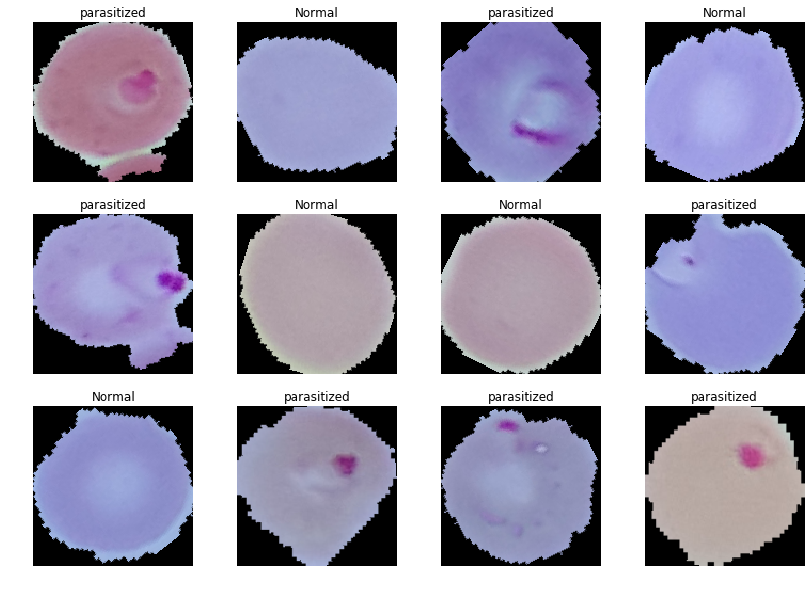

In [0]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(n_figures , data , encoder ,inv_normalize = None):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(12,datagen_object,encoder,inv_normalize)

In [0]:
from efficientnet_pytorch import EfficientNet

In [0]:
#define model
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.effnet = EfficientNet.from_pretrained('efficientnet-b3')
        self.linear1 = nn.Linear(1000,256)
        self.relu = nn.LeakyReLU()
        self.linear2 = nn.Linear(256,2)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.7)
    def forward(self, input):
        am = self.effnet(input)
        x = self.dropout(self.relu(self.linear1(am)))
        x = self.linear2(x)
        return x
model = classifier()
model.to(device)
criterion = nn.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b3


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


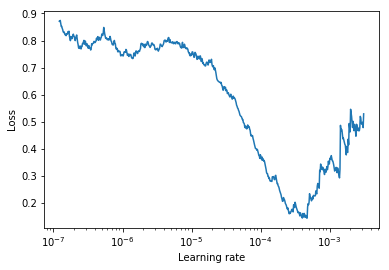

In [0]:
from lr_finder import LRFinder
optimizer_ft = optim.Adam(model.parameters(), lr=0.0000001)
lr_finder = LRFinder(model, optimizer_ft, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)
lr_finder.reset()
lr_finder.plot()

In [0]:
lr_finder.reset()

In [0]:
import numpy as np
import torch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc = []
loss_list = []
dataloaders = {'train': train_loader , 'val':valid_loader}

def train_model(model,criterion,num_epochs=10,lr=0.00008,batch_size=8):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    losses = []
    accuracy = []
    earlystop = EarlyStopping(patience = 3,verbose = True)
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%5==0):
            lr = 0.0001
        
        for phase in ['train','val']:
            if phase == ' train':
                model.train()  
            else:
                model.eval()       
            running_loss = 0.0
            running_corrects = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):   
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item()*data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
                if batch_idx % 500 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_acc,model)
            if(phase == 'Train'):
                losses.append(epoch_loss)
                accuracy.append(epoch_acc)
            print('{} Accuracy: '.format(phase),epoch_acc.item(),epoch_loss)
        if(earlystop.early_stop):
          print("Early stopping")
          model.load_state_dict(torch.load('./checkpoint.pt'))
          break
            
    return losses,accuracy

In [0]:
loss_train1,accuracy_train1 = train_model(model,criterion,50)

Epoch: 0
train Epoch: 0  [0/27558 (0%)]	Loss: 0.005000 	Acc: 1.000000
train Epoch: 0  [4000/27558 (18%)]	Loss: 0.054908 	Acc: 0.980040
train Epoch: 0  [8000/27558 (36%)]	Loss: 0.056592 	Acc: 0.980145
train Epoch: 0  [12000/27558 (54%)]	Loss: 0.067075 	Acc: 0.979014
train Epoch: 0  [16000/27558 (73%)]	Loss: 0.064768 	Acc: 0.979260
train Epoch: 0  [20000/27558 (91%)]	Loss: 0.062140 	Acc: 0.979208
train Accuracy:  0.9789096516690856 0.06244874890915325
val Epoch: 0  [0/27558 (0%)]	Loss: 0.041157 	Acc: 1.000000
Validation loss decreased (inf --> 0.975362).  Saving model ...
val Accuracy:  0.9753623188405797 0.10084392771771662
Epoch: 1
train Epoch: 1  [0/27558 (0%)]	Loss: 0.010124 	Acc: 1.000000
train Epoch: 1  [4000/27558 (18%)]	Loss: 0.060166 	Acc: 0.981038
train Epoch: 1  [8000/27558 (36%)]	Loss: 0.064613 	Acc: 0.979645
train Epoch: 1  [12000/27558 (54%)]	Loss: 0.062619 	Acc: 0.980180
train Epoch: 1  [16000/27558 (73%)]	Loss: 0.064304 	Acc: 0.979073
train Epoch: 1  [20000/27558 (91%)]	L

In [0]:
batch_size = 8
sm = nn.Softmax(dim = 1)
def test(model,dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        model.eval()
        output = model(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong
true,pred,image,true_wrong,pred_wrong = test(model,test_loader)

tensor(0.9779, device='cuda:0', dtype=torch.float64) 0.05825535213377367


In [0]:
torch.save(model,'./malaria_best.h5')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
   
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
true = np.asarray(true).astype(int)
pred = np.asarray(pred).astype(int)

Confusion matrix, without normalization
[[1373   15]
 [  27 1340]]


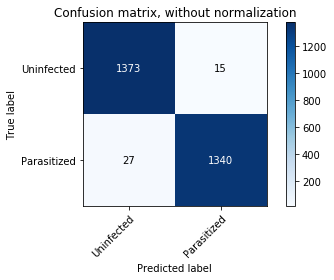

In [0]:
plot_confusion_matrix(true, pred, classes= class_names,title='Confusion matrix, without normalization')

In [0]:
class_names = ['Uninfected','Parasitized']

In [0]:
import sklearn
from sklearn.metrics import confusion_matrix
metrics.confusion_matrix(true, pred)

array([[1373,   15],
       [  27, 1340]])

In [0]:
sklearn.metrics.precision_score(true,pred,average='macro')

0.9848220875065894

In [0]:
sklearn.metrics.recall_score(true,pred,average='macro')

0.98472090169896

In [0]:
sklearn.metrics.accuracy_score(true,pred)

0.9847549909255898

In [0]:
sklearn.metrics.f1_score(true,pred,average='macro')


0.9847528032915286